In [97]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [98]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [99]:
print ('The shape of X is: ' + str(x_train.shape))
print ('The shape of y is: ' + str(y_train.shape))

The shape of X is: (60000, 28, 28)
The shape of y is: (60000,)


In [100]:
print ('The first element of y is: ', y_train[0])
print ('The last element of y is: ', y_train[-1])

The first element of y is:  5
The last element of y is:  8


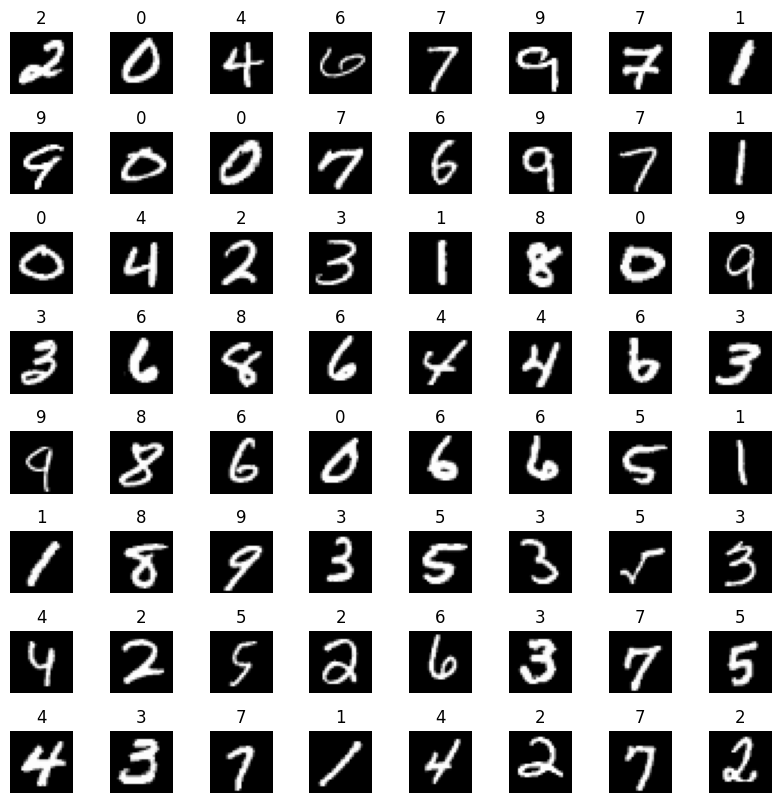

In [101]:
m = x_train.shape[0]

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train[random_index]
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y_train[random_index])
    ax.set_axis_off()

In [102]:
def calculate_new_dimension(size, kernel_size, stride, padding=0):
    return (size - kernel_size + 2 * padding) // stride + 1

In [103]:
def calculate_flattened_size(img_height, img_width, num_channels):
    # Calculate the size of the flattened layer after the last convolutional layer
    # This calculation needs to account for the changes in dimension after each conv layer
    # Example calculation (adjust based on your network's specifics):

    final_height = calculate_new_dimension(img_height, 8, 4, 2)

    final_width = calculate_new_dimension(img_width, 8, 4, 2)

    return final_height * final_width * num_channels

In [104]:
X_train = torch.tensor(x_train).unsqueeze(1).float() / 255
Y_train = torch.tensor(y_train).long()

X_test = torch.tensor(x_test).unsqueeze(1).float() / 255
Y_test = torch.tensor(y_test).long()

In [105]:
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

In [106]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1337)
num_samples = X_train.shape[0]
epochs = 1
learning_rate = 1e-3
batch_size = 64
num_batches = int(np.ceil(num_samples / batch_size))

In [107]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=14, kernel_size=8, stride=4, padding=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=calculate_flattened_size(28, 28, 14), out_features=10)
)

In [109]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()
m = model.to(device)

loss_history = []
acc_history = []

total_steps = len(train_loader)

In [110]:
model.train()
for epoch in range(epochs):
    for i, (X, y) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        output = model(X)
        loss_val = loss(output, y)
        loss_val.backward()
        optimizer.step()
        loss_history.append(loss_val.item())

        total = y.size(0)
        _, yhat = torch.max(output.data, 1)
        correct = (yhat == y).sum().item()
        acc_history.append(correct / total)

        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%"\
                    .format(
                        epoch + 1,
                        epochs, i + 1,
                        total_steps,
                        loss_val.item(),
                        (correct / total) * 100
                    )
            )
print("Finished Training")

Epoch [1/1], Step [100/938], Loss: 0.4522, Accuracy: 90.62%
Epoch [1/1], Step [200/938], Loss: 0.2042, Accuracy: 95.31%
Epoch [1/1], Step [300/938], Loss: 0.2966, Accuracy: 87.50%
Epoch [1/1], Step [400/938], Loss: 0.3552, Accuracy: 89.06%
Epoch [1/1], Step [500/938], Loss: 0.2531, Accuracy: 92.19%
Epoch [1/1], Step [600/938], Loss: 0.3010, Accuracy: 93.75%
Epoch [1/1], Step [700/938], Loss: 0.1461, Accuracy: 95.31%
Epoch [1/1], Step [800/938], Loss: 0.3871, Accuracy: 87.50%
Epoch [1/1], Step [900/938], Loss: 0.2075, Accuracy: 95.31%
Finished Training


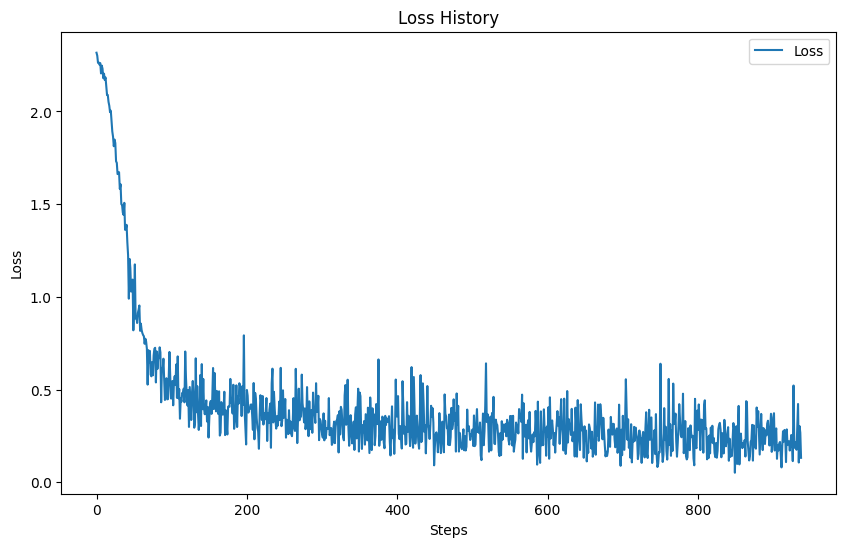

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.title('Loss History')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

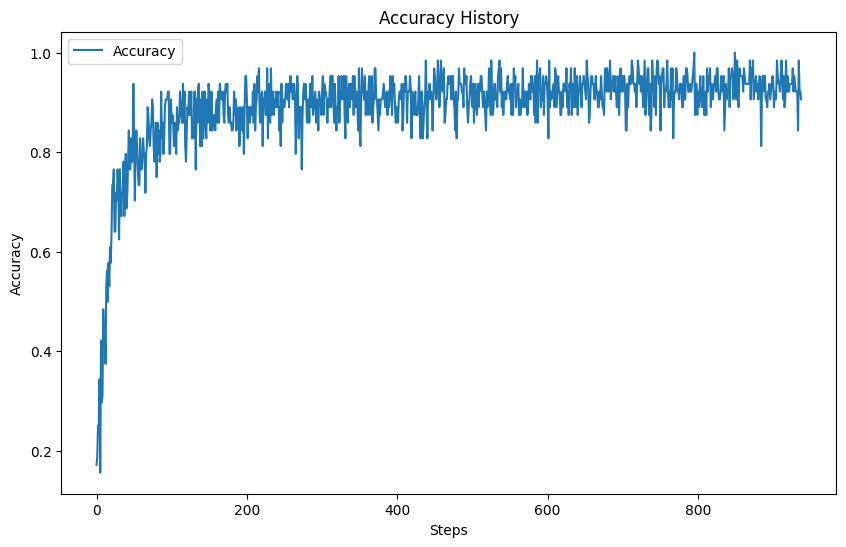

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(acc_history, label='Accuracy')
plt.title('Accuracy History')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [113]:
model.eval()
test_samples = X_test.shape[0]
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_loader:
        yhat = model(X)
        _, predicted = torch.max(yhat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    print(f"Test accuracy of the model on the {test_samples} test images: {correct / total * 100}%")

Test accuracy of the model on the 10000 test images: 93.73%


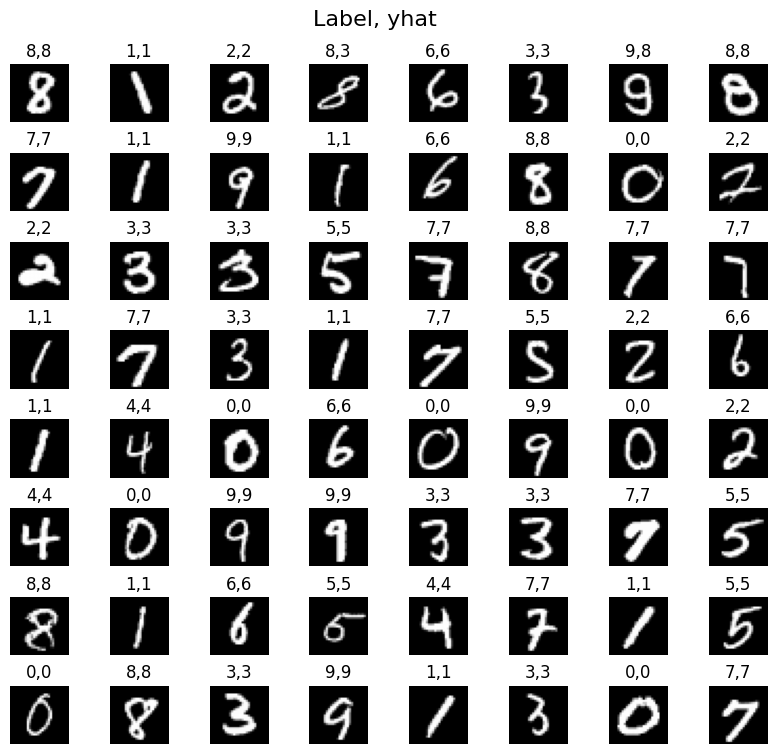

In [114]:
m = x_test.shape[0]

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X, y = x_test[random_index], y_test[random_index]

    X_tensor = torch.tensor(X).unsqueeze(0).unsqueeze(0).float() / 255
    
    # Display the image
    ax.imshow(X, cmap='gray')
    
    # Predict using the Neural Network
    output = model(X_tensor)
    _, yhat = torch.max(output.data, 1)
    yhat_val = yhat.item()
    
    # Display the label above the image
    ax.set_title(f"{y},{yhat_val}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()